<a href="https://colab.research.google.com/github/dilanHewawitharana/Intro-to-Deep-Learning-with-PyTorch/blob/master/Cassava_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1gKYciiiXHf7Lg6Iy1ncC5id3-o4eLPq4')

## Cassava Leaf Disease Classification

This is the course project of Deep Learning with PyTorch: Zero to GANs offered by Jovian Platform.

Task is to create deep learning model to classify cassava leaf disease. To get more information -> https://www.kaggle.com/c/cassava-leaf-disease-classification

Datatests from kaggle can be downloded from 'https://www.kaggle.com/c/cassava-leaf-disease-classification

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/c/cassava-leaf-disease-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dilansarith
Your Kaggle Key: ··········
cassava-leaf-disease-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


Next extract the downloded data

In [ ]:
import zipfile

with zipfile.ZipFile('/content/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('./cassava-leaf-disease-classification')

Define directory paths

In [ ]:
DATA_DIR = './cassava-leaf-disease-classification'

TRAIN_DIR = DATA_DIR + '/train_images' # Contains training images
TEST_DIR = DATA_DIR + '/test_images' # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv' # Contains real labels for training images
TEST_CSV = '/content/cassava-leaf-disease-classification/sample_submission.csv' # Contains dummy labels for test image

## Exploring the Data

Get some idea about data

In [ ]:
import pandas as pd

train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
len(train_df) # number of training data

21397

In [ ]:
import os
print(len(os.listdir(TRAIN_DIR))) # number of training images

21397


In [ ]:
# types of labels in the dataset
labels  = pd.read_json('/content/cassava-leaf-disease-classification/label_num_to_disease_map.json', 
                         orient='index')
labels 

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


helper functions to encode and decode lable values

In [ ]:
def encode_label(label):
    target = torch.zeros(5)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[0][i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

## Creating Datasets & Data Loaders

In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader

class CassavaLeafDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_id'], row['label']
        img_fname = self.root_dir + "/" + str(img_id)
        img = Image.open(img_fname)
        img= img.resize((400,500))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [ ]:
import torchvision.transforms as transforms

# define transformations
transform = transforms.Compose([transforms.ToTensor()])
dataset = CassavaLeafDataset(TRAIN_CSV, TRAIN_DIR, transform=transform)

In [ ]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Cassava Bacterial Blight (CBB)(0)


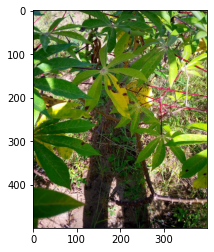

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

show_sample(*dataset[0], invert=False)

Labels: Cassava Bacterial Blight (CBB)(0)


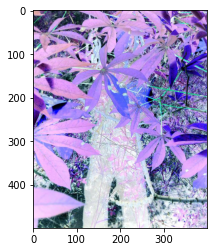

In [ ]:
show_sample(*dataset[0])

## Training & Validation sets

In [ ]:
torch.manual_seed(10)

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(19258, 2139)

## Data Loaders

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

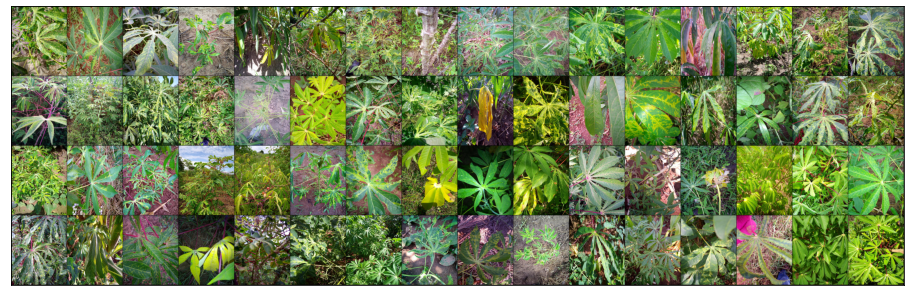

In [ ]:
from torchvision.utils import make_grid

show_batch(train_dl)

## Model

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))
        

In [ ]:
import torchvision.models as models

class CassavaLeafCnnModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                        nn.LeakyReLU(0.2, inplace=True),
                                        nn.Linear(256, 64),
                                        nn.LeakyReLU(0.2, inplace=True),
                                        nn.Linear(64, 5))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [ ]:
model = CassavaLeafCnnModel()
model

CassavaLeafCnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

RuntimeError: ignored

## Training the model

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CassavaLeafCnnModel(), device)

In [ ]:
evaluate(model, val_dl)

In [ ]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 1e-4

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

## predictions on individual images

In [ ]:
def predict_single(image, target):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Actual label: ", decode_target(target, text_labels=True))
    show_sample(image, prediction, invert=False)

In [ ]:
test_dataset = CassavaLeafDataset(TEST_CSV, TEST_DIR, transform=transform)

In [ ]:
img, target = test_dataset[0]
target

In [ ]:
predict_single(img, target)

## Generating test predictions

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

In [ ]:
sub_fname = 'resnet34_submission.csv'

In [ ]:
submission_df.to_csv(sub_fname, index=False)

## Save to Jovian

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.commit(project='Cassava-Leaf-Disease-Classification-final_project', outputs=[sub_fname])